## This is my notebook notes from a markowitz portfolio optimization course

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quandl
from quandlAPIKey import API_KEY

%matplotlib inline

In [2]:
quandl.ApiConfig.api_key = API_KEY

In [83]:
start_range = pd.to_datetime('2015-01-01')
end_range = pd.to_datetime('2020-01-01')

In [84]:
ibm = quandl.get("WIKI/IBM.4", start_date=start_range, end_date=end_range)
plug = quandl.get("WIKI/PLUG.4", start_date=start_range, end_date=end_range)
nee = quandl.get("WIKI/NEE.4", start_date=start_range, end_date=end_range)
aapl = quandl.get("WIKI/AAPL.4", start_date=start_range, end_date=end_range)

In [86]:
aapl.tail()

,Close
Date,
2018-03-21,171.270
2018-03-22,168.845
2018-03-23,164.940
2018-03-26,172.770
2018-03-27,168.340


In [6]:
## Above we pulled the closing price for the stock, however for historical stock data the adjusted closing price is also available. To keep the conditions similar to when working with real time data we will use the closing price

In [87]:
stocks = pd.concat([ibm, plug, nee, aapl], axis=1)

In [88]:
stocks.columns = ["IBM", "PLUG", "NEE", "AAPL"]

In [89]:
stocks.index = pd.to_datetime(stocks.index)

In [90]:
stocks.head(3)

,IBM,PLUG,NEE,AAPL
Date,,,,
2015-01-02,162.06,2.98,106.69,109.33
2015-01-05,159.51,3.01,105.56,106.25
2015-01-06,156.07,3.05,105.97,106.26


In [91]:
# stocks.pct_change(1).corr()

In [92]:
stocks.pct_change(1).head()

,IBM,PLUG,NEE,AAPL
Date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.015735,0.010067,-0.010591,-0.028172
2015-01-06,-0.021566,0.013289,0.003884,0.000094
2015-01-07,-0.006536,0.000000,0.009154,0.014022
2015-01-08,0.021735,0.009836,0.006078,0.038422


In [93]:
log_returns = np.log(stocks/stocks.shift(1))
log_returns.head(3)

,IBM,PLUG,NEE,AAPL
Date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.015860,0.010017,-0.010648,-0.028576
2015-01-06,-0.021802,0.013202,0.003877,0.000094


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea29ea6550>,
      dtype=object)

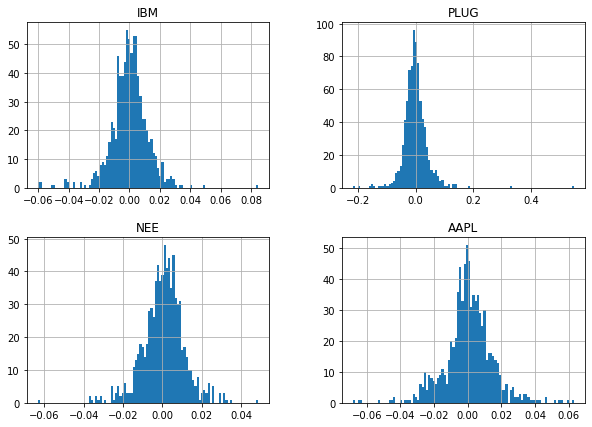

In [94]:
log_returns.hist(bins=100, figsize=(10,7))

In [95]:
log_returns.describe()

,IBM,PLUG,NEE,AAPL
count,812.000000,812.000000,812.000000,810.000000
mean,-0.000080,-0.000561,0.000519,0.000504
std,0.012408,0.044205,0.010591,0.014621
min,-0.060383,-0.216296,-0.063320,-0.067965
25%,-0.006319,-0.021724,-0.005161,-0.005894
50%,0.000273,-0.003802,0.000924,0.000388
75%,0.006201,0.017119,0.006509,0.008009
max,0.084934,0.548566,0.048732,0.062940


In [96]:
log_returns.cov()

,IBM,PLUG,NEE,AAPL
IBM,0.000154,0.000074,0.000032,0.000065
PLUG,0.000074,0.001954,0.000025,0.000093
NEE,0.000032,0.000025,0.000112,0.000028
AAPL,0.000065,0.000093,0.000028,0.000214


In [98]:
np.random.seed(101)

# Number of Portfolios to Simulate
portfolios = 3000
all_weights = np.zeros((portfolios, len(stocks.columns)))
returns_pouch = np.zeros(portfolios)
volatility_pouch = np.zeros(portfolios)
sharpe_pouch = np.zeros(portfolios)

for p in range(portfolios):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)

    # Save Weights
    all_weights[p, :] = weights
    # Expected Return
    returns_pouch[p] = np.sum((log_returns.mean() * weights) * 252)



    # Standard Deviation is the normal measure of volatility but it can be a flawed measure since stock returns may not always if ever have a normal distribution. Kurtosis is a good measure to how non-normal your distribution is, below is a faster linear algebra way of getting the volatility

    # Expected Volatility
    volatility_pouch[p] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_pouch[p] = returns_pouch[p] / volatility_pouch[p]

In [103]:
sharpe_pouch.max()

0.8563986098757925

In [104]:
sharpe_pouch.argmax()

890

In [101]:
all_weights[890,:]
max_sharpe_return = returns_pouch[890]
max_sharpe_volatility = volatility_pouch[890]

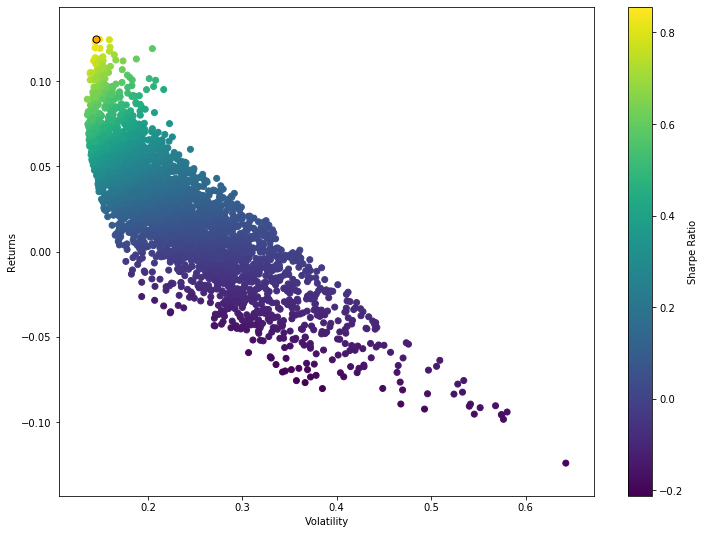

In [106]:
plt.figure(figsize=(12,9))
plt.scatter(volatility_pouch, returns_pouch, c=sharpe_pouch, cmap="viridis")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Returns")

plt.scatter(max_sharpe_volatility, max_sharpe_return, c="orange", s=50, edgecolors="black")

In [107]:
def get_returns_volatility_sharpe(weights):
    weights = np.array(weights)
    returns = np.sum(log_returns.mean() * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe_ratio = returns/volatility
    return np.array([returns, volatility, sharpe_ratio])

In [111]:
from scipy.optimize import minimize

In [112]:
def negative_sharpe(weights):
    # trying to minimize the negative sharpe ratio
    return get_returns_volatility_sharpe(weights)[2] * -1

In [113]:
def check_sum(weights):
    # return 0 if the sum of the weights is 1
    return np.sum(weights) - 1

In [114]:
constraints = ({"type": "eq", "fun": check_sum})

In [115]:
# function has to equal to 1 so bounds must equal 1
bounds = ((0,1),(0,1),(0,1),(0,1))

In [116]:
init_guess = [0.25, 0.25, 0.25, 0.25]

In [117]:
optimal_results = minimize(negative_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=constraints)

In [118]:
optimal_results

     fun: -0.880270006824341
     jac: array([ 5.64883463e-01,  1.42558432e+00, -2.59555876e-04,  5.98222017e-04])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.94556046e-15, 2.18558898e-15, 6.97407711e-01, 3.02592289e-01])

In [119]:
optimal_results.x

array([2.94556046e-15, 2.18558898e-15, 6.97407711e-01, 3.02592289e-01])

In [ ]:
# optimal sharpe ration is item [2]
get_returns_volatility_sharpe(optimal_results.x)

In [2]:
frontier_y = np.linspace(0,0.3,20)

NameError: name 'np' is not defined

In [ ]:
def minimize_volatility(weights):
    return get_returns_volatility_sharpe(weights)[1]

In [ ]:
frontier_volatility = []

for possible_return in frontier_y:
    # Grabs returns and substracts possible returns 
    cons = ({"type": "eq","fun": check_sum},
    {"type": "eq","fun": lambda w: get_returns_volatility_sharpe(w)[0] - possible_return})
    
    result = minimize(minimize_volatility, init_guess, method="SLSQP", bounds=bounds, constraints=cons)

    frontier_volatility.append(result["fun"])

In [ ]:
plt.figure(figsize=(12,9))
plt.scatter(volatility_pouch, returns_pouch, c=sharpe_pouch, cmap="viridis")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Returns")

plt.scatter(max_sharpe_volatility, max_sharpe_return, c="orange", s=50, edgecolors="black")

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=2)